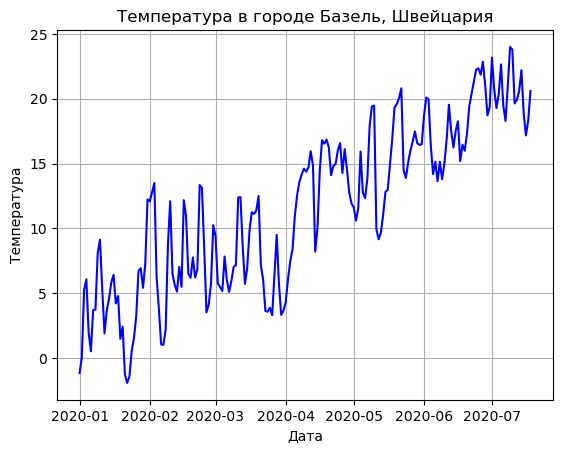

In [15]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

dataset = pd.read_csv('weather_data.csv', header=0, parse_dates=['datetime'])

dataset = dataset.set_index('datetime').resample("d").mean().asfreq('d')

df = dataset.iloc[:200,:]

plt.plot(df.index, df['temperature'], color="blue")
plt.title('Температура в городе Базель, Швейцария')
plt.xlabel('Дата')
plt.ylabel('Температура')
plt.grid()
plt.savefig('latex/extra/temperature.png')
plt.show()

есть единичные корни, ряд не стационарен
единичных корней нет, ряд стационарен


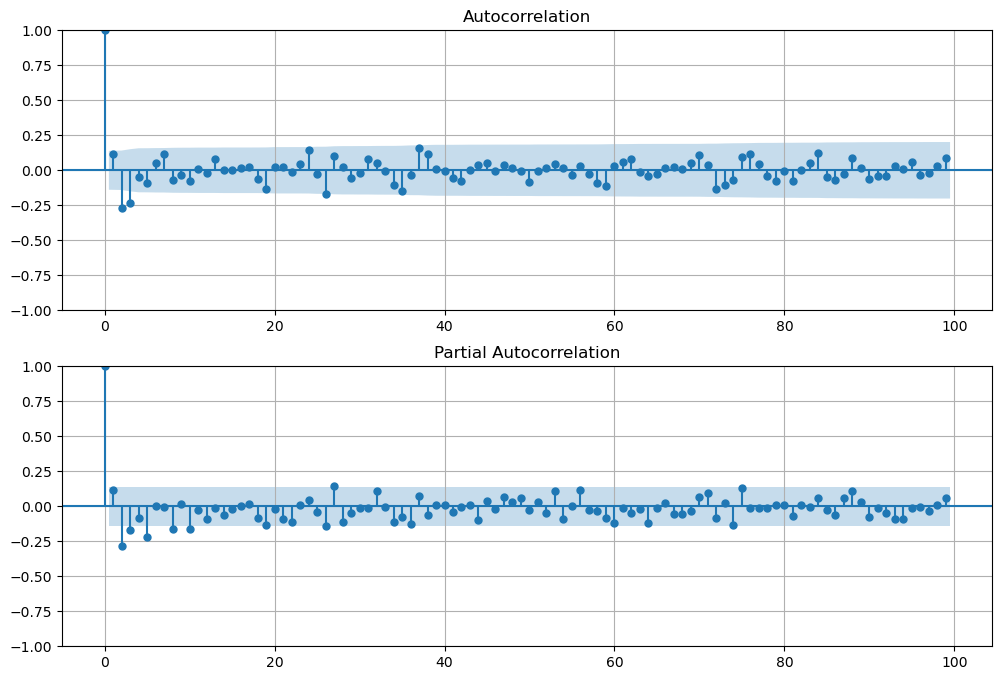

In [11]:
test = sm.tsa.adfuller(df['temperature'])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

df_diff = df['temperature'].diff(periods=1).dropna()
test = sm.tsa.adfuller(df_diff)
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')



fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_diff.dropna(), lags=99, ax=ax1)
plt.grid()
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_diff.dropna(), lags=99, ax=ax2)
plt.grid()
plt.savefig('latex/extra/acf_pacf.png')
plt.show()

/home/fackoff/.local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/fackoff/.local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.38436D+00    |proj g|=  3.14481D-01

At iterate    5    f=  2.26655D+00    |proj g|=  7.15151D-02

At iterate   10    f=  2.25628D+00    |proj g|=  2.08637D-03

At iterate   15    f=  2.25627D+00    |proj g|=  4.10184D-04

At iterate   20    f=  2.25626D+00    |proj g|=  5.49808D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     24     27      1     0     0   1.635D-05   2.256D+00
  F =   

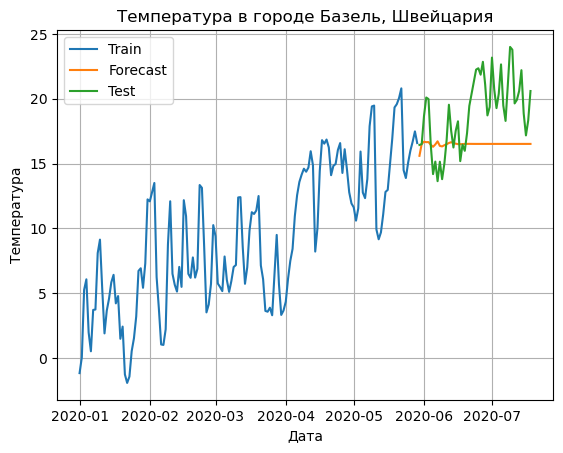

In [8]:
df.reset_index()

train = df.iloc[:-50,:]
test = df.iloc[-50:,:]

model = SARIMAX(train, order=(3, 1, 2), seasonal_order=(0, 0, 2, 8))
model_fit = model.fit()

fcast_len = len(test)
fcast = model_fit.forecast(fcast_len)

mse = mean_squared_error(test, fcast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, fcast)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')

plt.title('Температура в городе Базель, Швейцария')
plt.plot(train, label='Train')
plt.plot(fcast, label='Forecast')
plt.plot(test, label='Test')
plt.xlabel('Дата')
plt.ylabel('Температура')
plt.grid()
plt.legend()
plt.savefig('latex/extra/prediction.png')
plt.show()

Mean Squared Error: 2.885728192709077
Root Mean Squared Error: 1.6987431214604158
Mean Absolute Error: 1.468788413247244


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1369: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


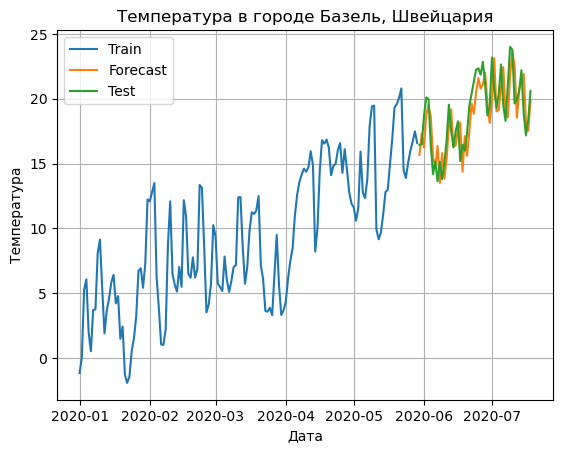

In [9]:
def rolling_forecast(train, test, order, season):
    history = train.iloc[:,:].asfreq('d')
    model = SARIMAX(history, order=order, seasonal_order=season)
    model_fit = model.fit(disp=False)
    predictions = []
    results = {}
    yhat = model_fit.forecast()

    predictions.append(yhat)
    history = pd.concat([history, pd.DataFrame([test.iloc[0,:]])]).asfreq('d')
    for i in range(1, len(test)):
        model = SARIMAX(history, order=order, seasonal_order=season)
        model_fit = model.fit(disp=False)
        yhat = model_fit.forecast()
        predictions.append(yhat)
        history = pd.concat([history, pd.DataFrame([test.iloc[i,:]])]).asfreq('d')
    mse = mean_squared_error(test, predictions)
    mae = mean_absolute_error(test, predictions)
    rmse = np.sqrt(mse)
    predictions = pd.Series(predictions, index=test.index)
    results['predictions'] = predictions
    results['mse'] = mse
    results['rmse'] = rmse
    results['mae'] = mae
    return results

rolling_fcast = rolling_forecast(train, test, (2, 1, 3), (0, 0, 2, 8))

print(f'Mean Squared Error: {rolling_fcast["mse"]}')
print(f'Root Mean Squared Error: {rolling_fcast["rmse"]}')
print(f'Mean Absolute Error: {rolling_fcast["mae"]}')

plt.title('Температура в городе Базель, Швейцария')
plt.plot(train, label='Train')
plt.plot(rolling_fcast['predictions'], label='Forecast')
plt.plot(test, label='Test')
plt.xlabel('Дата')
plt.ylabel('Температура')
plt.grid()
plt.legend()
plt.savefig('latex/extra/rolling_prediction.png')
plt.show()